<a href="https://colab.research.google.com/github/saintblue97/DeepNN_Optiver/blob/feature_engineering/james_10_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
#!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v optiver-trading-at-the-close        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
# !kaggle competitions leaderboard --show                       # print public leaderboard

- competition is now set to: optiver-trading-at-the-close


In [3]:
%%time
%%capture
%reset -f
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
pd.set_option('display.max_columns', 50, 'display.precision', 5, 'display.max_rows', 50)

CPU times: user 1.57 s, sys: 810 ms, total: 2.38 s
Wall time: 1.63 s


In [4]:
def is_google_colab():
    """Check if the environment is Google Colab.

    Returns:
        bool: True if in Google Colab, False otherwise.
    """
    try:
        import google.colab
        return True
    except ImportError:
      return False

if is_google_colab():
  file_path = ''
else:
  file_path = '/kaggle/input/optiver-trading-at-the-close/'

In [5]:
sample_submission_path = file_path + 'example_test_files/sample_submission.csv'

sample_submission = pd.read_csv(sample_submission_path); sample_submission

,time_id,row_id,target
0,26290,478_0_0,1
1,26290,478_0_1,1
2,26290,478_0_2,1
3,26290,478_0_3,1
4,26290,478_0_4,1
...,...,...,...
32995,26454,480_540_195,1
32996,26454,480_540_196,1
32997,26454,480_540_197,1
32998,26454,480_540_198,1


# Load Data

In [6]:
train_data_path = file_path + 'train.csv'
df = pd.read_csv(train_data_path);
df = df.dropna(subset=['target']); df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.18060e+06,1,0.99981,1.33803e+07,NaN,NaN,0.99981,60651.50,1.00003,8493.03,1.00000,-3.02970,0,0_0_0
1,1,0,0,1.66604e+05,-1,0.99990,1.64221e+06,NaN,NaN,0.99990,3233.04,1.00066,20605.09,1.00000,-5.51999,0,0_0_1
2,2,0,0,3.02880e+05,-1,0.99956,1.81937e+06,NaN,NaN,0.99940,37956.00,1.00030,18995.00,1.00000,-8.38995,0,0_0_2
3,3,0,0,1.19177e+07,-1,1.00017,1.83897e+07,NaN,NaN,1.00000,2324.90,1.00021,479032.40,1.00000,-4.01020,0,0_0_3
4,4,0,0,4.47550e+05,-1,0.99953,1.78606e+07,NaN,NaN,0.99939,16485.54,1.00002,434.10,1.00000,-7.34985,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.44072e+06,-1,1.00032,2.82804e+07,0.99973,0.99973,1.00032,32257.04,1.00043,319862.40,1.00033,2.31028,26454,480_540_195
5237976,196,480,540,3.49510e+05,-1,1.00064,9.18770e+06,1.00013,1.00039,1.00064,205108.40,1.00090,93393.07,1.00082,-8.22008,26454,480_540_196
5237977,197,480,540,0.00000e+00,0,0.99579,1.27254e+07,0.99579,0.99579,0.99579,16790.66,0.99588,180038.32,0.99580,1.16944,26454,480_540_197
5237978,198,480,540,1.00090e+06,1,0.99921,9.47733e+07,0.99921,0.99921,0.99897,125631.72,0.99921,669893.00,0.99901,-1.54018,26454,480_540_198


In [7]:
test_data_path = file_path + 'example_test_files/test.csv'
df_test  = pd.read_csv(test_data_path); df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
0,0,478,0,3753451.43,-1,0.99987,1.15490e+07,NaN,NaN,0.99987,22940.00,1.00005,9177.60,1.00000,26290,478_0_0
1,1,478,0,985977.11,-1,1.00025,3.85003e+06,NaN,NaN,0.99994,1967.90,1.00060,19692.00,1.00000,26290,478_0_1
2,2,478,0,599128.74,1,1.00058,4.35920e+06,NaN,NaN,0.99992,4488.22,1.00064,34955.12,1.00000,26290,478_0_2
3,3,478,0,2872317.54,-1,0.99980,2.71296e+07,NaN,NaN,0.99970,16082.04,1.00019,10314.00,1.00000,26290,478_0_3
4,4,478,0,740059.14,-1,0.99989,8.88089e+06,NaN,NaN,0.99972,19012.35,1.00011,7245.60,1.00000,26290,478_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.00032,2.82804e+07,0.99973,0.99973,1.00032,32257.04,1.00043,319862.40,1.00033,26454,480_540_195
32996,196,480,540,349510.47,-1,1.00064,9.18770e+06,1.00013,1.00039,1.00064,205108.40,1.00090,93393.07,1.00082,26454,480_540_196
32997,197,480,540,0.00,0,0.99579,1.27254e+07,0.99579,0.99579,0.99579,16790.66,0.99588,180038.32,0.99580,26454,480_540_197
32998,198,480,540,1000898.84,1,0.99921,9.47733e+07,0.99921,0.99921,0.99897,125631.72,0.99921,669893.00,0.99901,26454,480_540_198


In [8]:
print('Shape of training data =', df.shape)
print('Shape of testing data  =', df_test.shape)

Shape of training data = (5237892, 17)
Shape of testing data  = (33000, 16)


In [9]:
# n_val = 50000

tX, tY = df.drop('target', axis=1), df.target    # full training set

X_train = tX.copy()
y_train = tY.copy()

# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(tX, tY, test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

# Preprocessing

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression, Ridge, Lars
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder

from sklearn import set_config
set_config(transform_output = "pandas")

In [11]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Only drop columns that exist in X
        cols_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns=cols_to_drop)

class DataFrameSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean', fill_value=None):
        self.strategy_ = strategy
        self.fill_value_ = fill_value

    def fit(self, X, y=None):
        if self.strategy_ == 'mean':
            self.fill_values_ = X.mean()
        elif self.strategy_ == 'median':
            self.fill_values_ = X.median()
        elif self.strategy_ == 'constant':
            if self.fill_value_ is None:
                raise ValueError("fill_value must be provided for strategy='constant'")
            self.fill_values_ = pd.Series(self.fill_value_, index=X.columns)
        else:
            raise ValueError(f"Unknown strategy type: {self.strategy_}")

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill_values_)

class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, columns):
        self.window_size = window_size  # The size of the window for moving average
        self.columns = columns          # The columns on which to apply moving average

    def fit(self, X, y=None):
        return self  # No fitting process, so just return self

    def calculate_moving_average(self, series):
        return series.rolling(window=self.window_size).mean()

    def transform(self, X):
        X_new = X.copy()

        for col in self.columns:
            X_new[f'{col}_sma_{self.window_size}'] = X_new.groupby('stock_id')[col].transform(self.calculate_moving_average)

            X_new[f'{col}_sma_{self.window_size}'].fillna(X_new[col], inplace=True)


        return X_new


In [12]:
class LagFeatures(BaseEstimator, TransformerMixin):
    '''
    Scikit-Learn transfomer for creating lagged features.

    Parameters
    ----------
    steps : int - number of steps to lag

    Attributes
    ----------
    lag_steps : int - number of steps to lag
    cols: list - list of columns to lag
    lag_cols: list - list of lagged columns

    Methods
    -------

    '''
    def __init__(self, cols_to_lag, steps=1):
        self.lag_steps = steps
        self.cols_to_lag = cols_to_lag
        self.lag_cols = [f'{col} (t-{lag})' for lag in range(1, self.lag_steps+1) for col in self.cols_to_lag]

    def fit(self, X, y=None):
        return self

    def get_lag_features(self, X, lag):
            X_shift = X[self.cols_to_lag].shift(periods=lag).fillna(0)
            X_shift.columns = [f'{col} (t-{lag})' for col in self.cols_to_lag]

            return X_shift

    def transform(self, X):
        n_rows, n_cols = X.shape[0], len(self.lag_cols)

        X_lag = pd.DataFrame(np.zeros((n_rows, n_cols)), columns=self.lag_cols, index=X.index)
        for id, X_stock in X.groupby('stock_id'):
            for lag in range(1, self.lag_steps+1):
                stock_idxs = X_stock.index # Get the indexes of these rows for later

                X_shift = self.get_lag_features(X_stock, lag) # Shift down the stocks dataframe by `lag` step
                X_lag.loc[stock_idxs, X_shift.columns] = X_shift.values # assign the lagged values to the X_lag dataframe at the indexes for that stock

        return X_lag


In [13]:
def make_pipeline(num_cols, cat_cols, drop_cols):
    '''
    Scikit-learn pipeline for preprocessing.

    Parameters
    ----------
    num_cols : list - list of numerical columns
    cat_cols : list - list of categorical columns
    drop_cols : list - list of columns to drop

    Returns
    -------
    pipeline : Pipeline
    '''

    # Define ColumnTransformer for one-hot encoding
    cat_processor = Pipeline(
        steps=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]
    )

    num_processor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler()),
        ],
    )

    col_transformer = ColumnTransformer(
        transformers=[
            ('num', num_processor, num_cols),
            ('cat', cat_processor, cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=True
    )

    # Set up preprocessing pipeline
    pipeline = Pipeline(
        steps=[
            ('drop_columns', DropColumns(drop_cols)),
            # ('moving_average', MovingAverageTransformer(window_size=2, columns=num_cols)),
            ('col_transformer', col_transformer)
        ],
    )

    return pipeline

In [14]:
cat_cols  = ['imbalance_buy_sell_flag']
num_cols  = ['stock_id', 'ask_size','ask_price','bid_price','reference_price','wap', 'imbalance_size', 'matched_size', 'bid_size']
drop_cols = ['date_id', 'seconds_in_bucket', 'near_price', 'far_price', 'time_id', 'row_id']

pipeline = make_pipeline(num_cols, cat_cols, drop_cols)
X_transformed = pipeline.fit_transform(X_train)

# Hack for removing prefix from columns
X_transformed.columns = [col[5:] for col in X_transformed.columns]


In [15]:
X_transformed

,stock_id,ask_size,ask_price,bid_price,reference_price,wap,imbalance_size,matched_size,bid_size,imbalance_buy_sell_flag_-1,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1
0,-1.71565,-0.34852,-0.03799,0.01978,-0.02816,0.00593,-0.12354,-0.22682,0.07931,0.0,0.0,1.0
1,-1.69837,-0.25489,0.07494,0.03476,-0.01322,0.00593,-0.27045,-0.31076,-0.43601,1.0,0.0,0.0
2,-1.68109,-0.26734,0.01046,-0.05317,-0.07280,0.00593,-0.26381,-0.30950,-0.12438,1.0,0.0,0.0
3,-1.66381,3.28902,-0.00450,0.05314,0.03569,0.00593,0.30233,-0.19100,-0.44416,1.0,0.0,0.0
4,-1.64653,-0.41082,-0.03978,-0.05477,-0.07796,0.00593,-0.25676,-0.19478,-0.31707,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,1.65386,2.05855,0.03468,0.10985,0.06166,0.06443,-0.15961,-0.12027,-0.17553,1.0,0.0,0.0
5237976,1.67114,0.30780,0.11770,0.16800,0.11964,0.15200,-0.26154,-0.25680,1.37579,1.0,0.0,0.0
5237977,1.68842,0.97762,-0.77601,-0.69778,-0.74367,-0.74368,-0.27857,-0.23151,-0.31433,0.0,1.0,0.0
5237978,1.70570,4.76449,-0.18335,-0.13040,-0.13523,-0.17099,-0.22979,0.35522,0.66250,0.0,0.0,1.0


### Feature Engineering

In [16]:
ADD_LAG_FEATURES = True

if ADD_LAG_FEATURES:
    steps = 2
    cols_to_lag = ['ask_size', 'ask_price', 'bid_price','reference_price', 'wap']
    X_lag = LagFeatures(steps=steps, cols_to_lag=cols_to_lag).fit_transform(X_transformed)
    X_processed = pd.concat([X_transformed, X_lag], axis=1)
else:
    X_processed = X_transformed.copy()

X_processed

,stock_id,ask_size,ask_price,bid_price,reference_price,wap,imbalance_size,matched_size,bid_size,imbalance_buy_sell_flag_-1,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1,ask_size (t-1),ask_price (t-1),bid_price (t-1),reference_price (t-1),wap (t-1),ask_size (t-2),ask_price (t-2),bid_price (t-2),reference_price (t-2),wap (t-2)
0,-1.71565,-0.34852,-0.03799,0.01978,-0.02816,0.00593,-0.12354,-0.22682,0.07931,0.0,0.0,1.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1.69837,-0.25489,0.07494,0.03476,-0.01322,0.00593,-0.27045,-0.31076,-0.43601,1.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,-1.68109,-0.26734,0.01046,-0.05317,-0.07280,0.00593,-0.26381,-0.30950,-0.12438,1.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,-1.66381,3.28902,-0.00450,0.05314,0.03569,0.00593,0.30233,-0.19100,-0.44416,1.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,-1.64653,-0.41082,-0.03978,-0.05477,-0.07796,0.00593,-0.25676,-0.19478,-0.31707,1.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,1.65386,2.05855,0.03468,0.10985,0.06166,0.06443,-0.15961,-0.12027,-0.17553,1.0,0.0,0.0,0.54360,0.03468,0.10985,0.06166,0.06996,0.16089,0.03468,0.10985,0.06166,0.06782
5237976,1.67114,0.30780,0.11770,0.16800,0.11964,0.15200,-0.26154,-0.25680,1.37579,1.0,0.0,0.0,0.35987,0.11770,0.16800,0.11964,0.15111,0.26688,0.11770,0.16800,0.11964,0.15129
5237977,1.68842,0.97762,-0.77601,-0.69778,-0.74367,-0.74368,-0.27857,-0.23151,-0.31433,0.0,1.0,0.0,0.20379,-0.74270,-0.68101,-0.71041,-0.70997,0.13070,-0.72595,-0.64766,-0.69369,-0.69125
5237978,1.70570,4.76449,-0.18335,-0.13040,-0.13523,-0.17099,-0.22979,0.35522,0.66250,0.0,0.0,1.0,3.04810,-0.18335,-0.13040,-0.13523,-0.16743,5.62381,-0.14042,-0.08759,-0.13523,-0.11678


# Make submission

In [17]:
# from sklearn.metrics import make_scorer,mean_absolute_error
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier, SGDOneClassSVM
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# if is_google_colab():

#     models = [
#         LinearRegression(),
#         # Ridge(),
#         # BayesianRidge(),
#     ]


#     for model in models:
#         model_pipeline = Pipeline(preprocess_steps + [('model', model)])

#         scores = cross_val_score(model_pipeline, tX.copy(), tY.copy(), cv=5, scoring='neg_mean_absolute_error')

#         print(f'model={model} | score={np.mean(scores):.3f}{chr(177)} {np.std(scores):.3f}\n')

In [18]:
# Have to free up RAM so that the kernel doesnt crash during training
# del X_train
# del df

In [19]:
# lr = LinearRegression()
# lr.fit(X_processed, y_train)

In [20]:
lgm = lgb.LGBMRegressor()
lgm.fit(X_processed.values, y_train.values)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4797
[LightGBM] [Info] Number of data points in the train set: 5237892, number of used features: 22
[LightGBM] [Info] Start training from score -0.047561


LGBMRegressor()

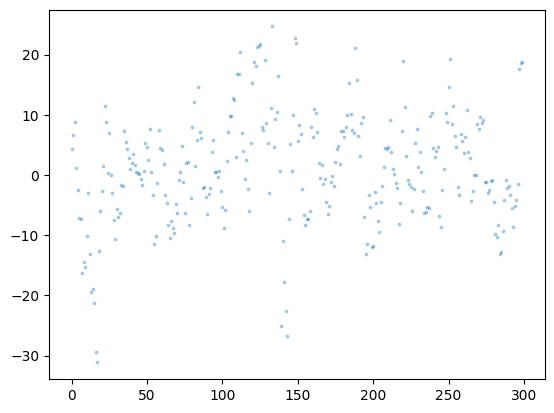

In [21]:
stock_id = 50
stock_idxs = np.where(X_train['stock_id'] == stock_id)[0]

stock_vals = y_train.iloc[stock_idxs][:300]
# stock_diffs = y_train.iloc[stock_idxs].diff()

plt.scatter(np.arange(len(stock_vals.index)), stock_vals.values, alpha=0.3, s=3);


In [22]:
# if not is_google_colab():
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [23]:
# Uncomment if you're debugging
# env.predict(pd.DataFrame())

def init_lag_dict(steps, cols):
    def create_lag_df(step, cols):
            lag_cols = [f'{col} (t-{step})' for col in cols]
            df_lag = pd.DataFrame(np.zeros((200, len(lag_cols))), columns=lag_cols)
            return df_lag

    lag_dict = {s: create_lag_df(s, cols) for s in range(1, steps+1)}
    return lag_dict

# Lists to store true and predicted targets

if ADD_LAG_FEATURES:
    lag_dict = init_lag_dict(steps, cols_to_lag)

if is_google_colab():

    true_targets = []
    predicted_targets = []

    for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test):

        # Preprocess test dataframe
        #   1. Pass test dataframe through pipeline
        #   2. With processed test dataframe, calculate lag features
        #      - Lag features are calculated from previous values in test dataframe
        #        so we have to keep a running track of the last x test dataframes
        test_transformed = pipeline.transform(test)
        test_transformed.columns = [col[5:] for col in test_transformed.columns]

        if ADD_LAG_FEATURES:
            test_lag = pd.concat([df for df in lag_dict.values()], axis=1)
            test_lag.columns = [f'{col} (t-{i})' for i in range(1, steps+1) for col in cols_to_lag ]
            test_processed = pd.concat([test_transformed, test_lag], axis=1)
        else:
            test_processed = test_transformed.copy()

        # Predict target values
        predictions = lgm.predict(test_processed)

        # Only take as many predictions and true targets as the minimum of the two
        min_len = min(len(predictions), len(revealed_targets))

        # Trim down the predictions list so that it is the same size as the revealed targets
        current_predictions = predictions[:min_len]
        current_true_targets = revealed_targets['revealed_target'].values[:min_len]

        # Extend the lists of true targets and predictions with the ones from the current batch
        true_targets.extend(current_true_targets)
        predicted_targets.extend(current_predictions)

        # Make the actual prediction and add to sample_prediction df
        sample_prediction['target'] = predictions

        # Submit the predictions for this chunk of test data
        env.predict(sample_prediction)

        # Append this iteration of test into the lag dictionary
        # and push the current lag features away (i.e (t-1) features become (t-2) features...)
        if ADD_LAG_FEATURES:
            for s in range(1, steps):
                lag_dict[s+1] = lag_dict[s]

            lag_dict[1] = test_transformed[cols_to_lag]


    # Convert lists to dataframes
    df_true = pd.DataFrame(true_targets, columns=['true_target'])
    df_pred = pd.DataFrame(predicted_targets, columns=['predicted_target'])

    # Calculate and print the MAE
    display(df_pred)

    mae = mean_absolute_error(df_true.fillna(0), df_pred)
    print("Mean Absolute Error:", mae)
#     # 5.261823197997517

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,predicted_target
0,-1.05252
1,2.00530
2,2.25488
3,-0.67994
4,-1.12494
...,...
757,0.04338
758,-0.08522
759,-0.21383
760,-0.19611


Mean Absolute Error: 5.465513852313288
